# Stability calculations

## -- LUVOIR --

In notebook 10, we calculated the PASTIS modes for all three currently designed apodizers for the LUVOIR A pupil. In this notebook, we will load the modes and calculate the maximum mode contributions $\sigma$ and strability requirements $\Delta \sigma$.

After that I also calculate the maximum segment contributions $\mu$.

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from astropy.io import fits
import astropy.units as u
import hcipy as hc

os.chdir('../../pastis/')
import util_pastis as util
from e2e_simulators.luvoir_imaging_onephot import LuvoirAPLC

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16

## Instantiate a simple SM for mode plotting

I need to simplify this... I can make a child class like I did for the full LUVOIR simulator.

In [3]:
# Load aperture files needed for SM
nseg = 120
wvln = 638e-9

datadir = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
aper_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000.fits'
aper_ind_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000_indexed.fits'
aper_read = hc.read_fits(os.path.join(datadir, aper_path))
aper_ind_read = hc.read_fits(os.path.join(datadir, aper_ind_path))

pupil_grid = hc.make_pupil_grid(dims=aper_ind_read.shape[0], diameter=15)
aper = hc.Field(aper_read.ravel(), pupil_grid)
aper_ind = hc.Field(aper_ind_read.ravel(), pupil_grid)

wf_aper = hc.Wavefront(aper, wvln)

# Load segment positions from fits header
hdr = fits.getheader(os.path.join(datadir, aper_ind_path))

poslist = []
for i in range(nseg):
    segname = 'SEG' + str(i+1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))
    
poslist = np.transpose(np.array(poslist))
seg_pos = hc.CartesianGrid(hc.UnstructuredCoords(poslist))

## Mode and eigenvalue units

Since the matrices got generated normalized to an aberration of 1 nm, everything stemming from the matrix will be in units of **nanometers**. --> This is the desired behaviour of course and is yet to be confirmed, which is one of the goals of this notebook.

In [4]:
eunit = 1e-9

## Also instantiate a LUVOR telescope

For cumulative contrast calculation.

> **ATTENTION:** the variable `apodizer_design` has to be correct for the data we are reading with the variable `savedpath` further below!!!

In [5]:
# Instantiate LUVOIR
Nzernike = 4
sampling = 8
apodizer_design = 'medium'
# This path is specific to the paths used in the LuvoirAPLC class
optics_input = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
luvoir = LuvoirAPLC(optics_input, apodizer_design, sampling)

/Users/pueyo/anaconda3/envs/pastis-new-hcipy/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:68: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


In [6]:
75072585048.78731

75072585048.78731

In [7]:
np.sum(luvoir.wf_aper.electric_field)

Field(676346.5+0.j)

0.9901351881964329
7900238672998.9375


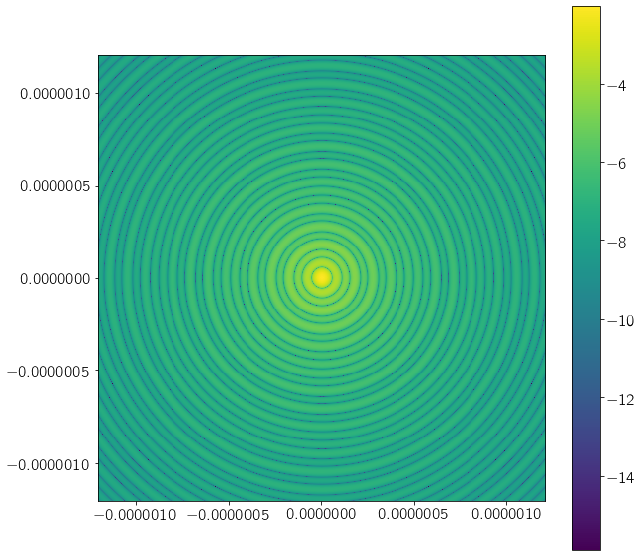

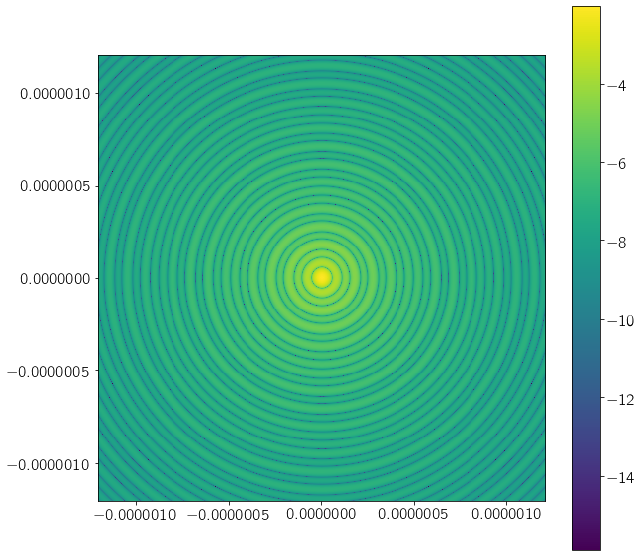

In [8]:
test_pup = luvoir.lyotstop/np.sqrt(np.sum(luvoir.lyotstop**2))
test_pupW = hc.Wavefront(test_pup,luvoir.wvln)
test_foc = luvoir.prop_norm(test_pupW)
plt.figure(figsize=(10, 10))
hc.imshow_field(np.log10(test_foc.intensity))
plt.colorbar()
print(np.sum(test_foc.intensity))
test_foc2 = luvoir.prop(test_pupW)
plt.figure(figsize=(10, 10))
hc.imshow_field(np.log10(test_foc.intensity))
plt.colorbar()
print(np.sum(test_foc2.intensity))

In [9]:
luvoir.make_LO_Modes(15)
luvoir.make_DM(4)
luvoir.make_segment_zernike_primary(1)
luvoir.make_HI_Modes(16)

In [10]:
n_LO = luvoir.zm.num_actuators
n_MID = luvoir.sm.num_actuators
n_HI = luvoir.fm.num_actuators
n_DM = luvoir.dm.num_actuators
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)

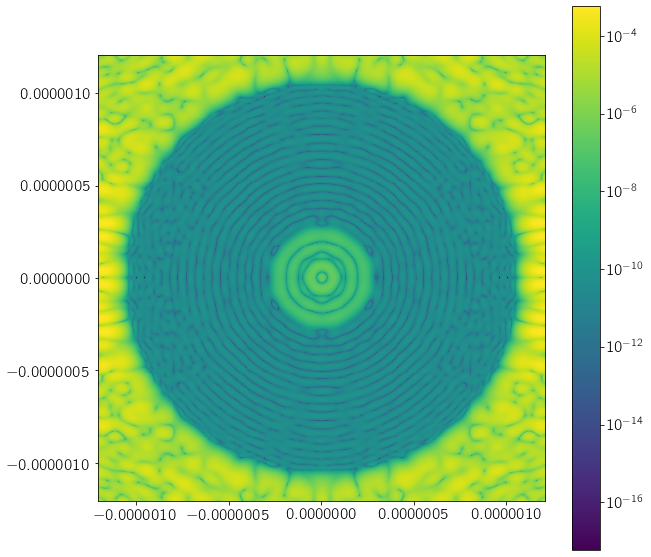

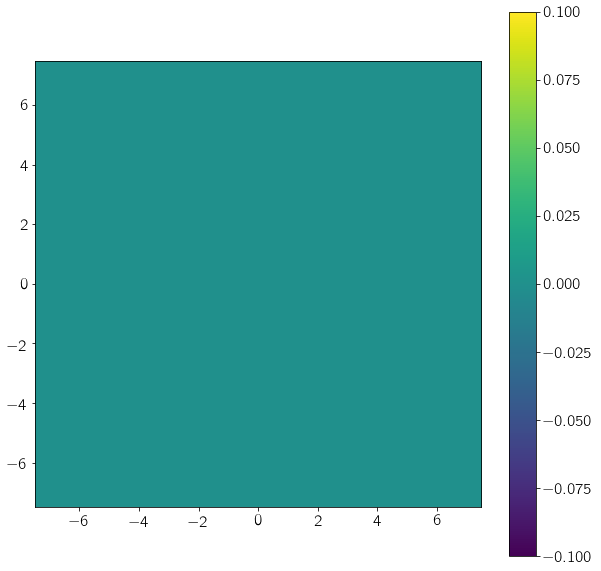

In [29]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
LO_modes[14] = eunit/2*0
luvoir.zm.actuators = LO_modes
psf_unaber, ref = luvoir.calc_psf(ref=True)
norm = ref.max()
psf_test, ref = luvoir.calc_psf(ref=True)
norm = ref.max()
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_unaber/norm, norm=LogNorm())
plt.colorbar()
wf_dm = luvoir.zm(luvoir.wf_aper)
plt.figure(figsize=(10, 10))
hc.imshow_field(wf_dm.phase/(2*np.pi/luvoir.wvln))
plt.colorbar()

In [12]:
# OBWFS_zernike_step = np.pi/2
# OBWFS_zernike_spot_diam = 1.06
# OBWFS_zernike_spot_points = 128
# OBWFS_zernike_pupil_downsample = 10
# OBWFS_zernike_Npup = np.int(luvoir.pupil_grid.shape[0]/OBWFS_zernike_pupil_downsample)
# OBWFS_zernike_pup_diam = luvoir.diam
# OBWFS_zernike_ref_wave = luvoir.wf_aper.wavelength
# OBWFS_zernike_grid =  hc.field.make_pupil_grid(OBWFS_zernike_Npup, diameter=15.)
# zernike = hc.wavefront_sensing.ZernikeWavefrontSensorOptics(OBWFS_zernike_grid, phase_step=OBWFS_zernike_step, 
#                                                             phase_dot_diameter=OBWFS_zernike_spot_diam, num_pix=OBWFS_zernike_spot_points,
#                                                             pupil_diameter=1/OBWFS_zernike_pup_diam, reference_wavelength=1/OBWFS_zernike_ref_wave)

In [13]:
# input_wf = luvoir.wf_aper
# zernike_ref = zernike.forward(input_wf)
# zernike_ref_sub_real = hc.field.subsample_field(zernike_ref.real,10,grid_zernike, statistic='mean')
# zernike_ref_sub_imag = hc.field.subsample_field(zernike_ref.imag,10,grid_zernike, statistic='mean')

In [14]:
# LO_modes = np.zeros(n_LO)
# MID_modes = np.zeros(n_MID)
# HI_modes = np.zeros(n_HI)
# DM_modes = np.zeros(n_DM)
# luvoir.zm.actuators = LO_modes
# luvoir.sm.actuators = MID_modes
# luvoir.fm.actuators = HI_modes
# luvoir.dm.actuators = DM_modes
# input_wf = luvoir.wf_aper
# zernike_ref = zernike.forward(input_wf)
# zernike_ref2 = luvoir.prop_OBWFS()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(zernike_ref.intensity)
# plt.colorbar()
# HI_modes[14] = eunit/2
# luvoir.fm.actuators = HI_modes
# wf_dm = luvoir.fm(luvoir.wf_aper)
# zernike_meas = zernike.forward(wf_dm)
# zernike_meas2 = luvoir.prop_OBWFS()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(zernike_meas.intensity)
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(zernike_meas.intensity - zernike_ref.intensity)
# plt.colorbar()

In [15]:
# plt.figure(figsize=(10, 10))
# hc.imshow_field(zernike_ref2.intensity)
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(zernike_meas2.intensity)
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(zernike_meas2.intensity - zernike_ref2.intensity)
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(zernike_meas2.intensity - zernike_ref2.intensity -(zernike_meas.intensity - zernike_ref.intensity))
# plt.colorbar()

In [30]:
apod_prop = hc.Apodizer(luvoir.apodizer)

In [41]:
# z_step = np.pi/2
# z_diam =1.06
# z_np = 128
z_pup_downsample = 10
N_pup_z = np.int(luvoir.pupil_grid.shape[0]/z_pup_downsample)
# z_pup_diam = luvoir.diam
# z_ref_wave = luvoir.wf_aper.wavelength
# zernike_coeffs = np.zeros([luvoir.sm.num_actuators])
# zernike_coeffs= np.random.uniform(-mu_map*eunit/2,mu_map*eunit/2,number_of_modes)/np.sqrt(2)
# luvoir.sm.actuators = zernike_coeffs*100
# chiotte = luvoir.sm(luvoir.wf_aper)
grid_zernike =  hc.field.make_pupil_grid(N_pup_z, diameter=15.)

In [49]:
np.angle(1j)

1.5707963267948966

In [45]:
zernike_meas_sub_I.shape

(10000,)

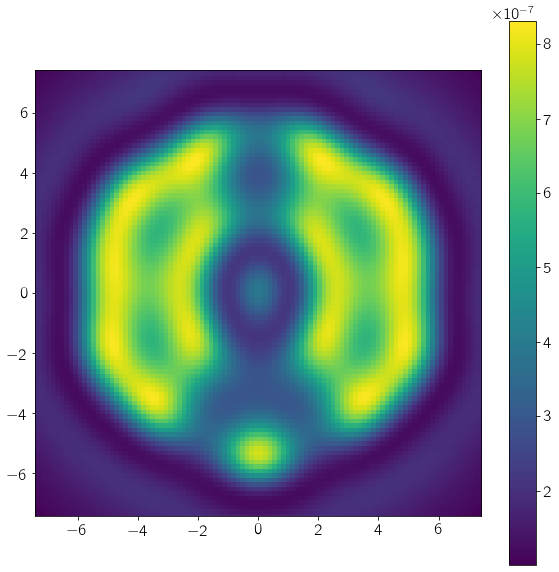

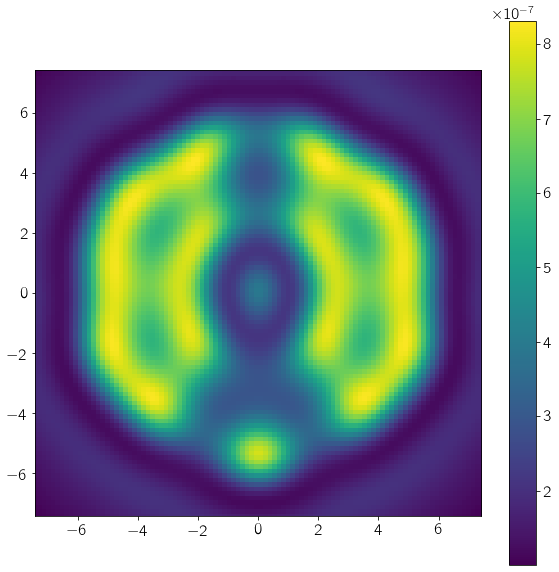

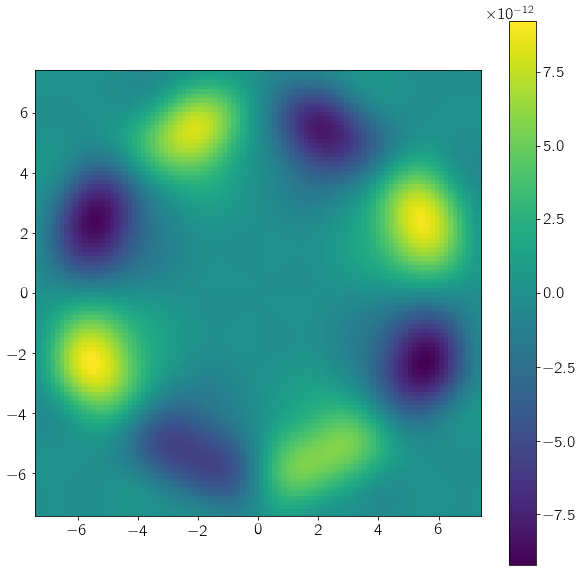

In [44]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
input_wf = luvoir.wf_aper
zernike_ref = luvoir.prop_LOWFS()
zernike_ref_sub_real = hc.field.subsample_field(zernike_ref.real,10,grid_zernike, statistic='mean')
zernike_ref_sub_imag = hc.field.subsample_field(zernike_ref.imag,10,grid_zernike, statistic='mean')
zernike_ref_sub_I = zernike_ref_sub_real**2 + zernike_ref_sub_imag**2
plt.figure(figsize=(10, 10))
hc.imshow_field(zernike_ref_sub_I)
plt.colorbar()
LO_modes[14] = eunit/2*0.001
luvoir.zm.actuators = LO_modes
zernike_meas = luvoir.prop_LOWFS()
zernike_meas_sub_real = hc.field.subsample_field(zernike_meas.real,10,grid_zernike, statistic='mean')
zernike_meas_sub_imag = hc.field.subsample_field(zernike_meas.imag,10,grid_zernike, statistic='mean')
zernike_meas_sub_I = zernike_meas_sub_real**2 + zernike_meas_sub_imag**2
plt.figure(figsize=(10, 10))
hc.imshow_field(zernike_meas_sub_I)
plt.colorbar()
plt.figure(figsize=(10, 10))
hc.imshow_field(zernike_meas_sub_I - zernike_ref_sub_I)
plt.colorbar()

In [ ]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
input_wf = luvoir.wf_aper
zernike_ref = luvoir.prop_LOWFS()
plt.figure(figsize=(10, 10))
hc.imshow_field(zernike_ref.intensity)
plt.colorbar()
LO_modes[14] = eunit/2*0.001
luvoir.zm.actuators = LO_modes
zernike_meas = luvoir.prop_LOWFS()
plt.figure(figsize=(10, 10))
hc.imshow_field(zernike_meas.intensity)
plt.colorbar()
plt.figure(figsize=(10, 10))
hc.imshow_field(zernike_meas.intensity - zernike_ref.intensity)
plt.colorbar()

In [33]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
input_wf = luvoir.wf_aper
zernike_ref = luvoir.prop_LOWFS()

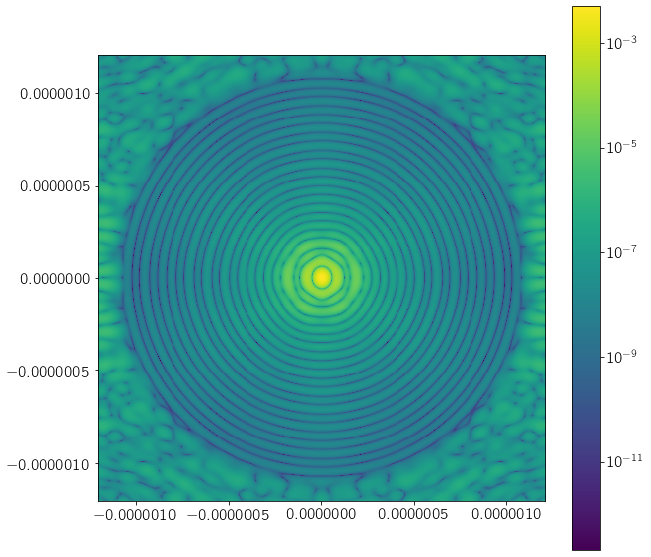

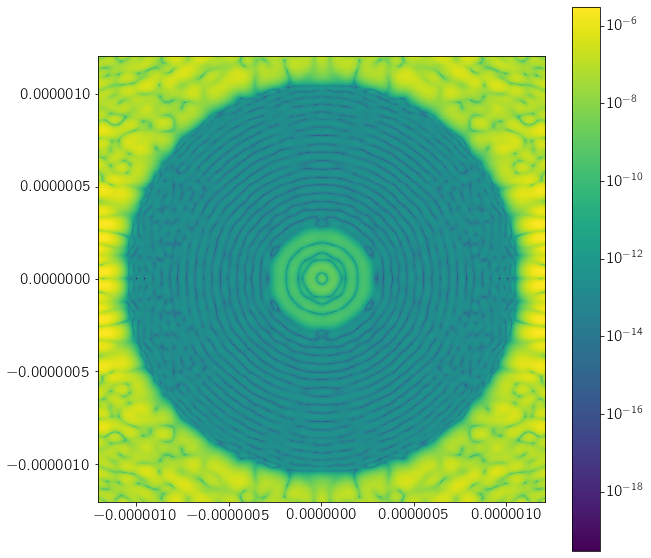

In [34]:
plt.figure(figsize=(10, 10))
hc.imshow_field(ref, norm=LogNorm())
plt.colorbar()
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_unaber, norm=LogNorm())
plt.colorbar()

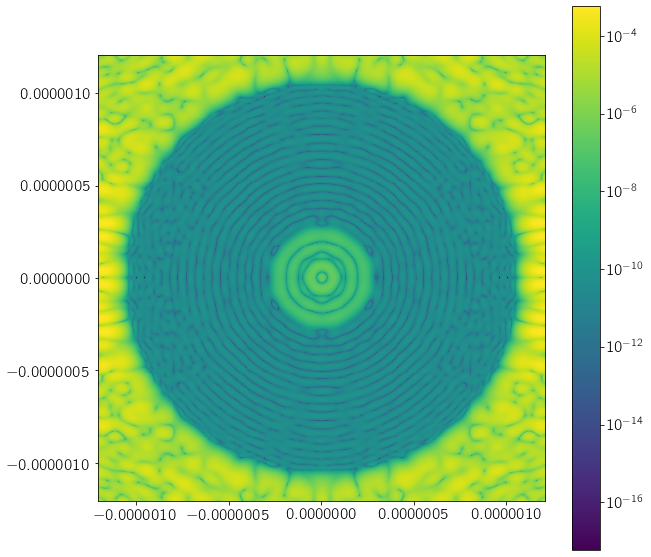

In [35]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
psf_test, ref = luvoir.calc_psf(ref=True)
norm = ref.max()
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_unaber/norm, norm=LogNorm())
plt.colorbar()

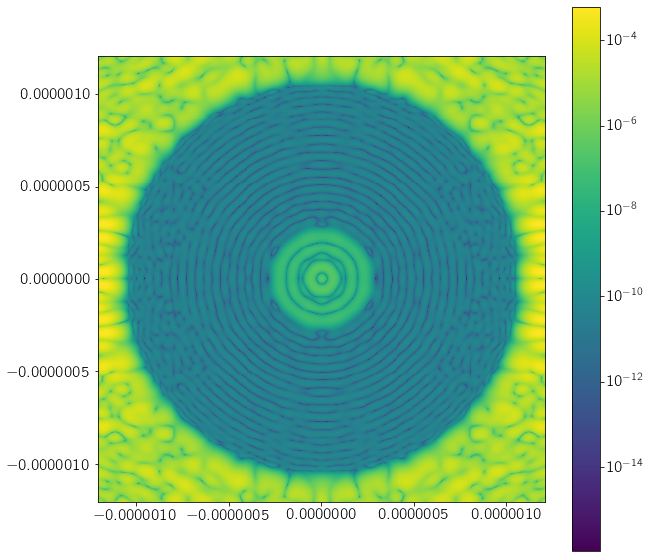

In [36]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
LO_modes[4] = eunit
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
psf_unaber, ref = luvoir.calc_psf(ref=True)
norm = ref.max()
psf_test, ref = luvoir.calc_psf(ref=True)
norm = ref.max()
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_unaber/norm, norm=LogNorm())
plt.colorbar()

## Read eigenmodes and eigenvalues

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


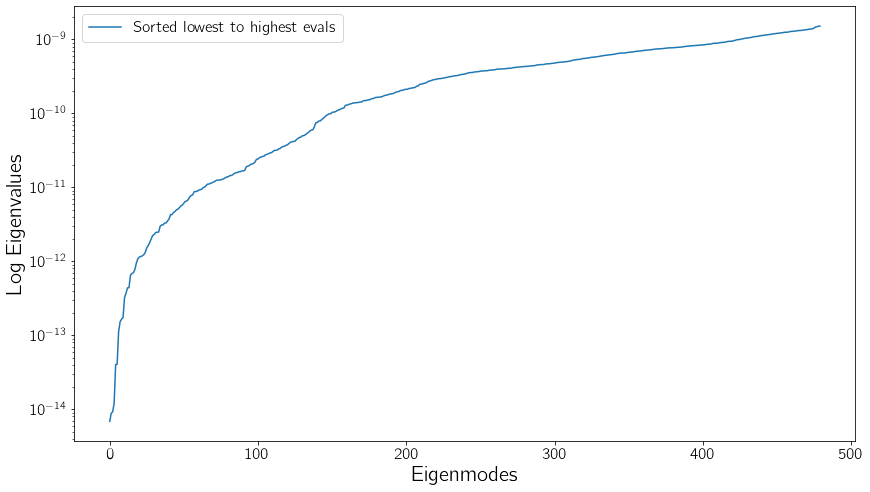

In [17]:
evals, evecs = np.linalg.eig(matrix)
sorted_evals = np.sort(evals)
sorted_indices = np.argsort(evals)
sorted_evecs = evecs[:, sorted_indices]
plt.figure(figsize=(14, 8))
#plt.plot(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evals, label='Sorted lowest to highest evals')
plt.semilogy()
plt.xlabel('Eigenmodes')
plt.ylabel('Log Eigenvalues')
plt.legend()

In [18]:
# # Lets compute all modes now for LUVOIR with an HCIPy SM
# emodes = []

# for mode in range(len(evals)):
#     print('Working on mode {}/{}.'.format(mode+1, len(evals)))
    
#     zernike_coeffs = eunit*sorted_evecs[:, mode]/2
#     luvoir.sm.actuators = zernike_coeffs
#     wf_sm = luvoir.sm(luvoir.wf_aper)
#     emodes.append(wf_sm.phase)

## Stability requirements

### Static contrast and static contribution

According to Lucie's paper, we can get the maximum aberration $\sigma_p$ we can allow per mode $p$ if we want to obtain a contrast $C$ directly from the according eigenvalue $\lambda_p$.

$$\sigma_p = \sqrt{\frac{C_p}{\lambda_p}}$$

Where $C_p$ is the contrast contribution from mode $p$ only. For simplicity, we assume that all modes have the same contribution to the total contrast $C$, meaning

$$C = C_1 + C_2 + ... + C_N$$

with $N$ being the total number of modes. This also means

$$C_p = \frac{C}{N}$$

Since we have one mode that has a really low eigenvalue and essentially on contribution, we can take that mode out and assume that the other $N-1$ modes bear all the contrast contributions, changing it to

$$C_p = C_1 + C_2 + ... + C_{N-1}$$

and

$$C_p = \frac{C}{N-1}$$

So we can calculate the maximum ocntribution of a mode $\sigma_p$ with

$$\sigma_p = \sqrt{\frac{C}{(N-1)\lambda_p}}$$

We have 120 segments, so $N=120$ and we will aim to achieve a static contrast of $C = 10^{-10}$.

Note how we start numbering at 1 here, to stay consistent with our segment numbering, but when doing these things in Python we need to start numbering at 0.

Skype with Lucie, have to include baseline contrast $C_0$:

$$\sigma_p = \sqrt{\frac{C-C_0}{(N-1)\lambda_p}}$$

In [19]:
number_of_modes = luvoir.sm.num_actuators

In [20]:
c_stat = 1e-11
print('Static contrast: {}'.format(c_stat))
print('N = {}'.format(number_of_modes))

Static contrast: 1e-11
N = 480


1.5427744189916925


Text(0, 0.5, 'Max mode contribution $\\sigma_p$ (nm)')

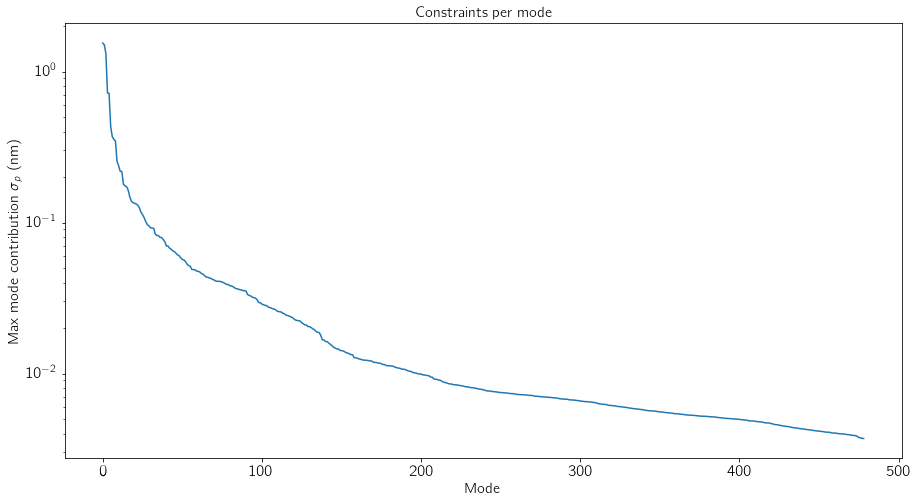

In [21]:
# Calculate single sigma - remember that we start numbering at 0 because of python
def get_sigma(cstat, nseg, eigenval, c_zero):
#     sigma = np.sqrt((cstat - c_zero) / ((nseg-1)*eigenval))
    sigma = np.sqrt((cstat) / ((nseg-1)*eigenval))

    return sigma
p = 1
sigma_p = get_sigma(c_stat, number_of_modes, sorted_evals[p], baseline_contrast)
print(sigma_p)
sigmas = get_sigma(c_stat, number_of_modes, sorted_evals, baseline_contrast)
plt.figure(figsize=(15, 8))
plt.plot(sigmas[1:])
plt.semilogy()
plt.title('Constraints per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\sigma_p$ (nm)', size=15)

### Dynamic contast and dynamic contribution

We want $\Delta C = 10^{-11}$. This "dynamic contast" is the error on the contrast $C$ which we want to limit, so we write it as

$$\Delta C = \sqrt{\Delta C_1^2 + \Delta C_2^2 + ... \Delta C_N^2} = \sqrt{N \Delta C_p^2} = \sqrt{N} \Delta C_p$$

which also means

$$\Delta C_p = \frac{C}{\sqrt{N}}$$

and then again because we discard that non-contributing mode, we actually have

$$\Delta C_p = \frac{C}{\sqrt{N-1}}$$

For the $\Delta \sigma_p$ we can use the same equation like for the $\sigma_p$, but we plug in $\Delta C$ instead of $C$.

$$\Delta \sigma_p = \sqrt{\frac{\Delta C}{\lambda_p}} = \sqrt{\frac{\Delta C}{\sqrt{(N-1)}\ \lambda_p}}$$

Text(0, 0.5, 'Max mode contribution $\\Delta \\sigma_p$ (nm)')

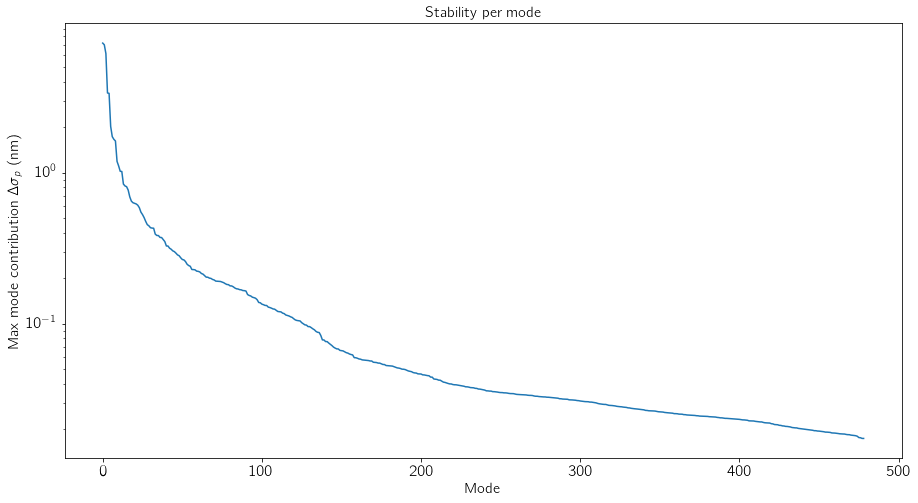

In [22]:
c_dyn = 1e-11
# Calculate the Delta Cs
def get_delta_sigma(cdyn, nseg, eigenval):
    del_sigma = np.sqrt(cdyn / (np.sqrt(nseg-1)*eigenval))
    return del_sigma
del_sigmas = get_delta_sigma(c_dyn, number_of_modes, sorted_evals)
plt.figure(figsize=(15, 8))
plt.plot(del_sigmas[1:])
plt.semilogy()
plt.title('Stability per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\Delta \sigma_p$ (nm)', size=15)

## Segment based constraints

In [23]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16

In [24]:
c_target = 1e-10

In [28]:
number_of_modes = luvoir.sm.num_actuators
# Calculate the inverse of the pastis MODE matrix
modestosegs = np.linalg.pinv(sorted_evecs)

# # Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
# c_avg = []
# for i in range(number_of_modes):
#     c_avg.append(util.pastis_contrast(sorted_evecs[:, i] * u.nm, matrix) + baseline_contrast)

# # Calculate segment requirements
# mu_map = np.sqrt(
#     ((c_target - baseline_contrast) / number_of_modes) / (np.dot(c_avg - baseline_contrast, np.square(modestosegs))))

# Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
c_avg = []
for i in range(number_of_modes):
    c_avg.append(util.pastis_contrast(sorted_evecs[:, i] * u.nm, matrix) )

# Calculate segment requirements
mu_map = np.sqrt(
    ((c_target ) / number_of_modes) / (np.dot(c_avg, np.square(modestosegs))))

In [29]:
psf_unaber, ref, inter_unaber = luvoir.calc_psf(ref=True, return_intermediate='efield')

contrast: 3.138762127845071e-10


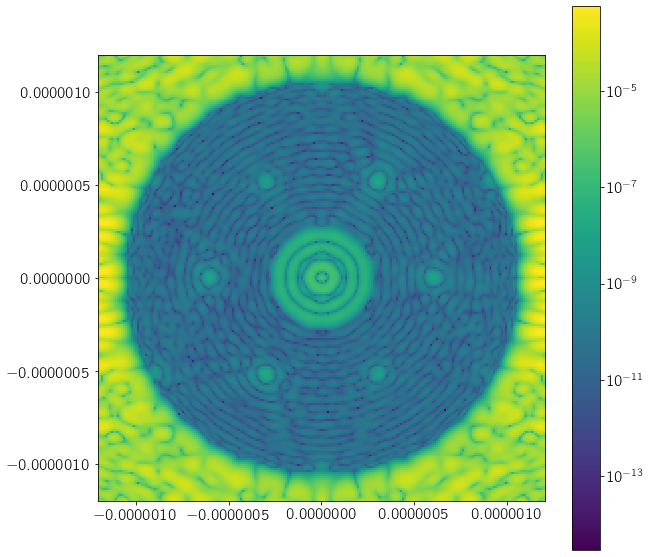

In [30]:
zernike_coeffs = mu_map*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref, inter = luvoir.calc_psf(ref=True, return_intermediate='efield')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf.intensity/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = np.abs(psf.electric_field - psf_unaber.electric_field)**2/norm 
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
print('contrast:', test_contrast)

In [31]:
N_zernike = 4
zernike_coeffs_numaps = np.zeros([N_zernike,number_of_modes])
for qq in range(N_zernike):
    zernike_coeffs_tmp = np.zeros([number_of_modes])
    for pp in range(120):
        zernike_coeffs_tmp[qq+(pp)*N_zernike] = mu_map[qq+(pp)*N_zernike]
    zernike_coeffs_numaps[qq] = zernike_coeffs_tmp
nu_maps = []
for qq in range(N_zernike):
    zernike_coeffs = eunit*zernike_coeffs_numaps[qq]/2
    luvoir.sm.actuators = zernike_coeffs
    nu_maps.append(luvoir.sm(luvoir.wf_aper).phase/luvoir.wf_aper.wavenumber)

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

Text(0.5, 1, 'Segment Level Piston ')

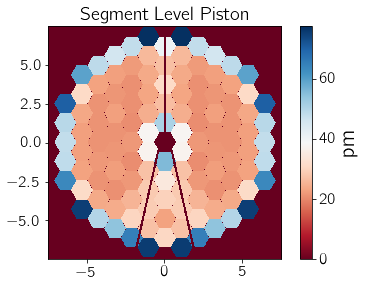

In [33]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[0]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level Piston ')

contrast: 1.6456593538649357e-12


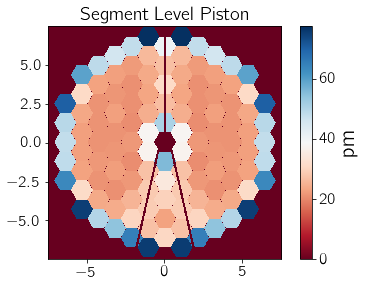

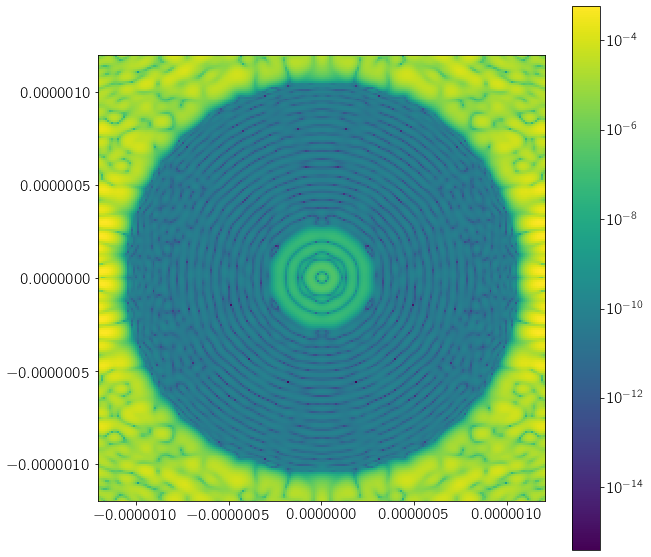

In [34]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[0]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level Piston ')
zernike_coeffs = zernike_coeffs_numaps[0]*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])- baseline_contrast
print('contrast:', test_contrast)

contrast: 2.3500624721920724e-11


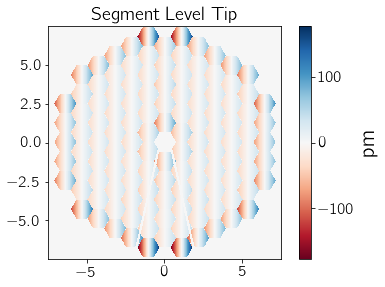

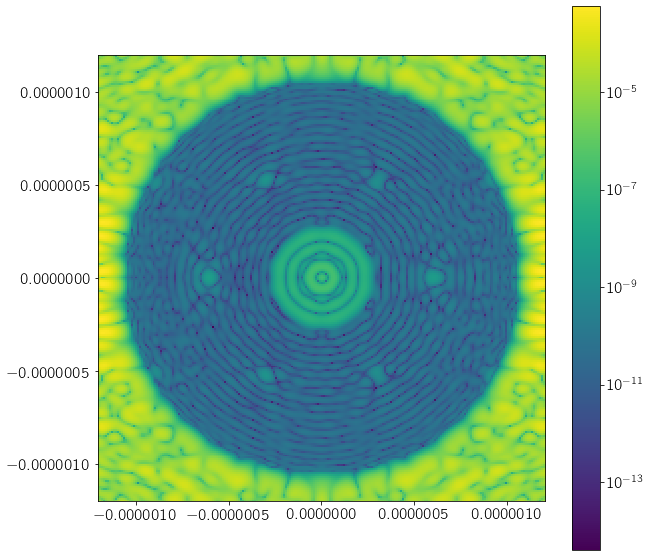

In [35]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[1]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level Tip ')
zernike_coeffs = zernike_coeffs_numaps[1]*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)

contrast: 2.3369635593827038e-11


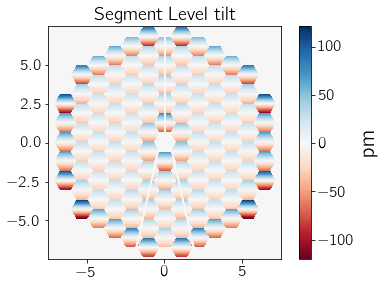

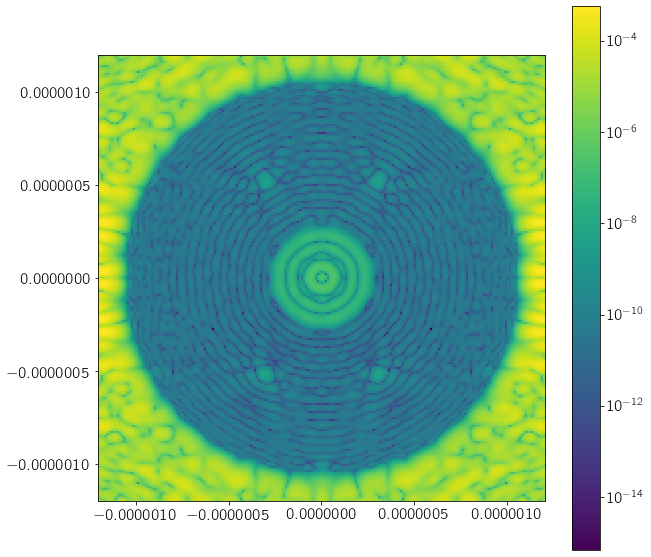

In [36]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[2]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level tilt ')
zernike_coeffs = zernike_coeffs_numaps[2]*eunit / 2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)

contrast: 3.059988326188137e-11


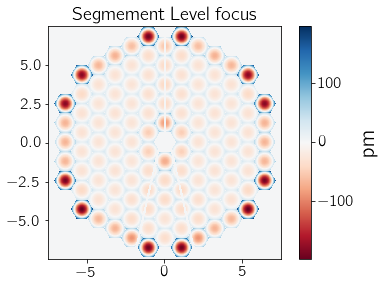

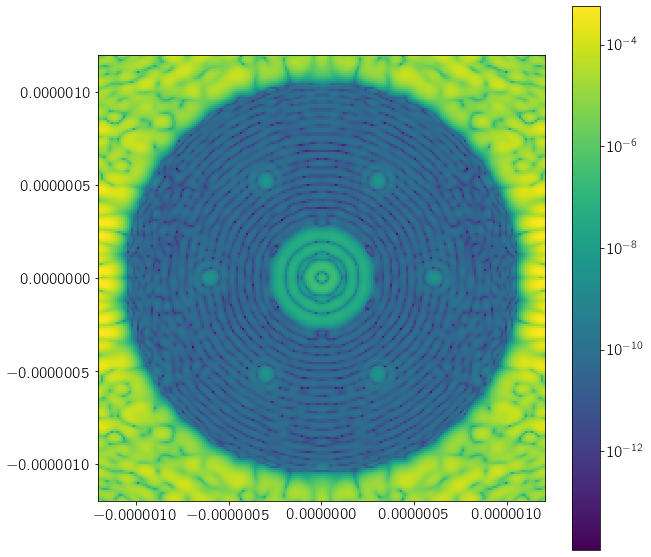

In [37]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[3]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segmement Level focus ')
zernike_coeffs = zernike_coeffs_numaps[3]*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)

In [38]:
# fig, ax = plt.subplots(ncols=1)
# img1 = hc.imshow_field(nu_maps[4]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
# clb = fig.colorbar(img1)
# clb.set_label('pm', rotation=90)
# plt.tight_layout(h_pad=1)
# plt.title('Segmement Level twisted focus 1 ')
# zernike_coeffs = zernike_coeffs_numaps[3]*eunit/2
# luvoir.sm.actuators = zernike_coeffs
# luvoir.sm(luvoir.wf_aper)
# psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
# plt.figure(figsize=(10, 10))
# hc.imshow_field(psf/norm, norm=LogNorm())
# plt.colorbar()
# dh_intensity = psf/norm * dh_mask
# test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
# print('contrast:', test_contrast)

In [39]:
# fig, ax = plt.subplots(ncols=1)
# img1 = hc.imshow_field(nu_maps[5]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
# clb = fig.colorbar(img1)
# clb.set_label('pm', rotation=90)
# plt.tight_layout(h_pad=1)
# plt.title('Segment Level twisted focus 2 ')
# zernike_coeffs = zernike_coeffs_numaps[3]*eunit/2
# luvoir.sm.actuators = zernike_coeffs
# luvoir.sm(luvoir.wf_aper)
# psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
# plt.figure(figsize=(10, 10))
# hc.imshow_field(psf/norm, norm=LogNorm())
# plt.colorbar(aspect = 4)
# dh_intensity = psf/norm * dh_mask
# test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
# print('contrast:', test_contrast)

In [40]:
n_repeat = 30
all_contr_rand_seg = []
all_random_maps = []
for rep in range(n_repeat):
    print('Segment realization {}/{}'.format(rep + 1, n_repeat))
    zernike_coeffs = np.random.uniform(-mu_map*eunit,mu_map*eunit,number_of_modes)
    luvoir.sm.actuators = zernike_coeffs
    luvoir.sm(luvoir.wf_aper)
    psf, ref, inter = luvoir.calc_psf(ref=True, return_intermediate='efield')
#     plt.figure(figsize=(10, 10))
#     hc.imshow_field(psf.intensity/norm, norm=LogNorm())
#     plt.colorbar()
    dh_intensity = np.abs(psf.electric_field - psf_unaber.electric_field)**2/norm 
    test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
    all_contr_rand_seg.append(test_contrast) 
    print('contrast:', test_contrast)
    

Segment realization 1/30
contrast: 3.299363233611296e-10
Segment realization 2/30
contrast: 3.2907390690751893e-10
Segment realization 3/30
contrast: 3.558407510496357e-10
Segment realization 4/30
contrast: 3.3886170317433903e-10
Segment realization 5/30
contrast: 2.98741037765137e-10
Segment realization 6/30
contrast: 3.7566982815218116e-10
Segment realization 7/30
contrast: 3.513519795931313e-10
Segment realization 8/30
contrast: 3.264944198218088e-10
Segment realization 9/30
contrast: 3.434997459564034e-10
Segment realization 10/30
contrast: 3.473827547902813e-10
Segment realization 11/30
contrast: 3.500542389344257e-10
Segment realization 12/30
contrast: 3.60897346650179e-10
Segment realization 13/30
contrast: 3.362032258936882e-10
Segment realization 14/30
contrast: 3.2969666458439534e-10
Segment realization 15/30
contrast: 3.5441822112477443e-10
Segment realization 16/30
contrast: 3.2291338464236144e-10
Segment realization 17/30
contrast: 3.244722410062345e-10
Segment realization

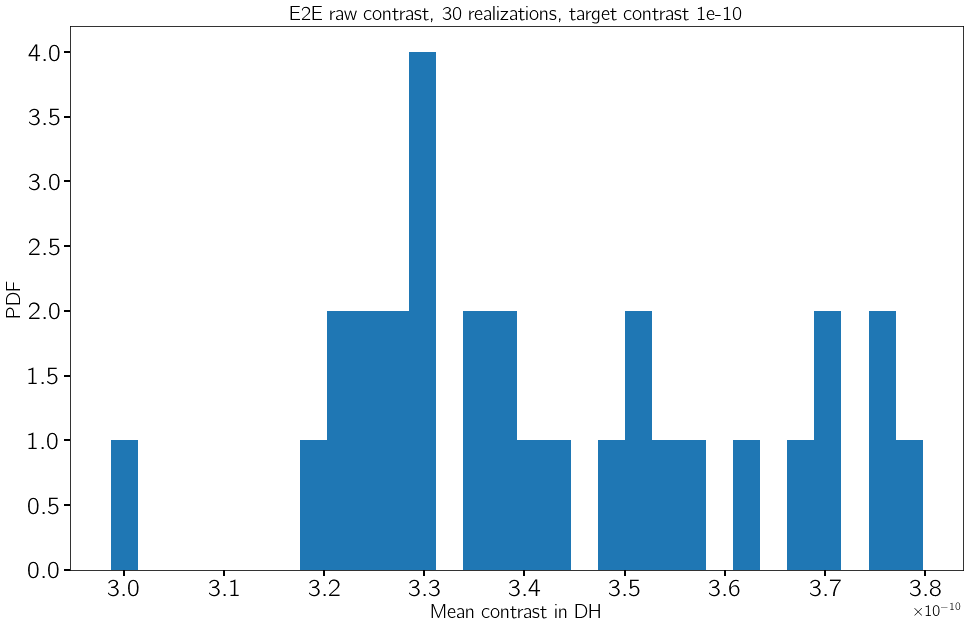

In [41]:
plt.figure(figsize=(16, 10))
plt.hist(all_contr_rand_seg,30)
plt.title('E2E raw contrast, {} realizations, target contrast 1e-10'.format(n_repeat), size=20)
plt.xlabel('Mean contrast in DH', size=20)
plt.ylabel('PDF', size=20)
plt.tick_params(axis='both', which='both', length=6, width=2, labelsize=25)

# Now running the proper radiometry

In [207]:
###### m = 10e-12;
c = 10e-12;
Jy = 10e-23;
bw = 0.1;
h  = 6.6256*10e-27
Nph = 3.836e3*(10e-23*10e4)/(6.6256e0*10e-27)

In [213]:
Nph*15**2/1e14

1.3026744747645498

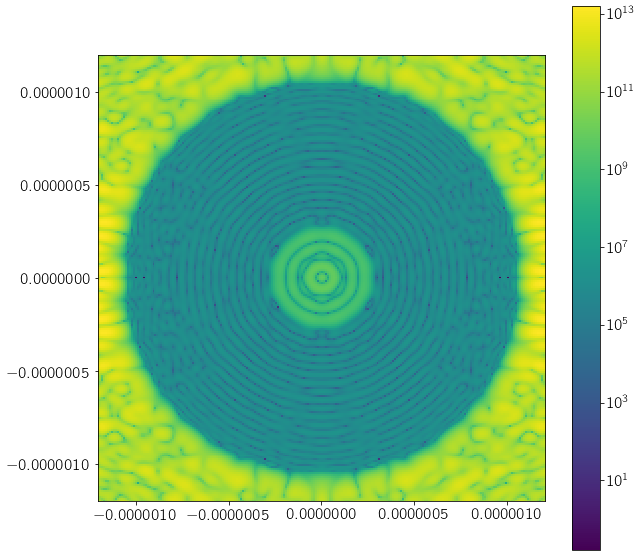

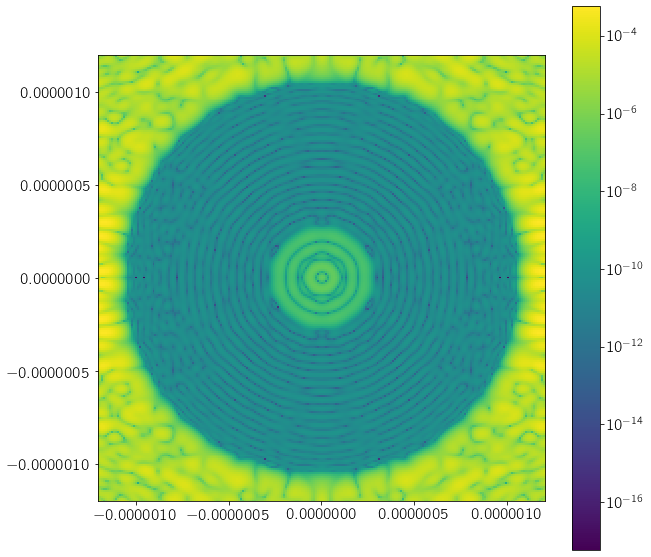

In [197]:
circle = hc.aperture.circular_aperture(luvoir.diam)
circular_aperture = hc.evaluate_supersampled(circle,luvoir.pupil_grid,oversampling = 1)
flux_circle = Nph*np.pi*(luvoir.diam/2)**2
norm_aperture = np.sum(luvoir.aperture.data)/np.sum(circular_aperture.data)
zernike_coeffs = np.zeros([Nzernike*120])
luvoir.sm.actuators = zernike_coeffs
wf_sm = luvoir.sm(luvoir.wf_aper)
psf_I, ref_I = luvoir.calc_psf(ref=True)
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_I, norm=LogNorm())
plt.colorbar()
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_I/np.max(ref_I), norm=LogNorm())
plt.colorbar()

In [198]:
aperture_energy = np.sum(np.asarray(luvoir.aperture.data)**2)

In [201]:
ref_I_1phot = ref_I/aperture_energy

0.9999999999999998


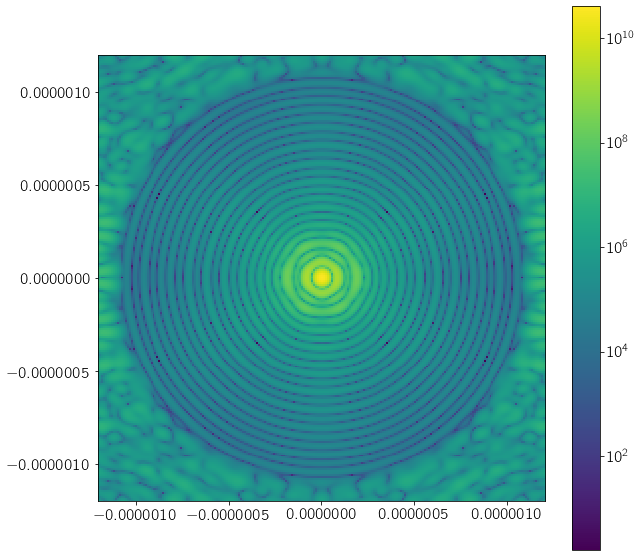

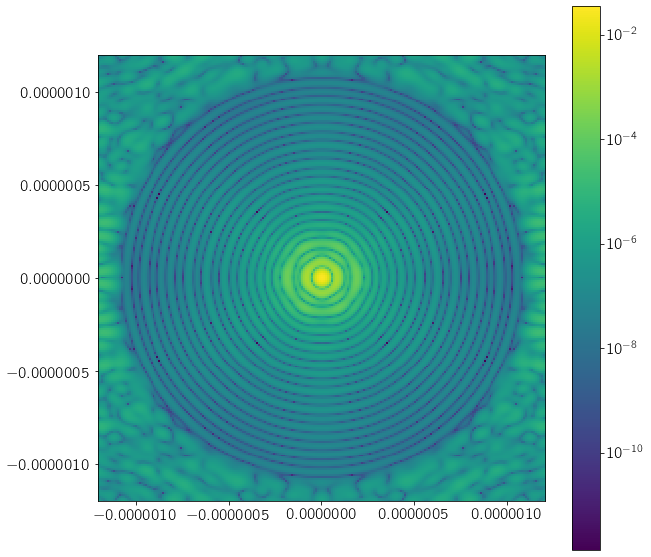

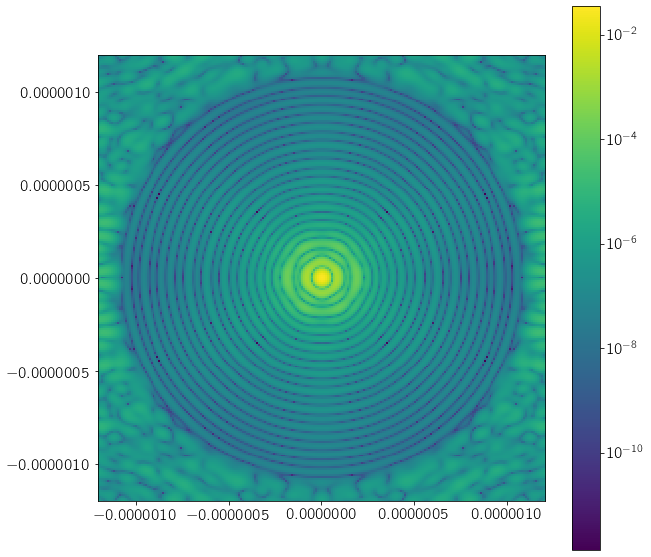

In [200]:
plt.figure(figsize=(10, 10))
hc.imshow_field(ref_I_1phot, norm=LogNorm())
plt.colorbar()
plt.figure(figsize=(10, 10))
hc.imshow_field(ref_I_1phot/np.sum(ref_I_1phot), norm=LogNorm())
plt.colorbar()
ref_I_1phot_conserved = ref_I_1phot/np.sum(ref_I_1phot)
plt.figure(figsize=(10, 10))
hc.imshow_field(ref_I_1phot_conserved, norm=LogNorm())
plt.colorbar()
print(np.sum(ref_I_1phot_conserved))

In [47]:
norm_photons = np.sum(ref_I_1phot)*aperture_energy

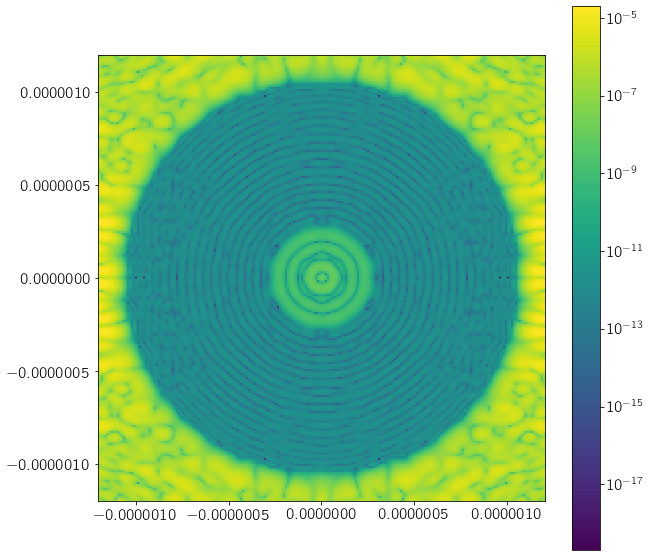

In [48]:
zernike_coeffs = np.zeros([Nzernike*120])
luvoir.sm.actuators = zernike_coeffs
wf_sm = luvoir.sm(luvoir.wf_aper)
psf_I, ref_I = luvoir.calc_psf(ref=True)
psf_I_1phot_conserved =  psf_I/norm_photons
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_I_1phot_conserved, norm=LogNorm())
plt.colorbar()

In [49]:
test2 = (psf_I_1phot_conserved)*dh_mask
test3 = np.mean(test2[np.where(test2 != 0)])
print(test3)
test2 = (psf_I_1phot_conserved/np.max(ref_I_1phot_conserved))*dh_mask
test3 = np.mean(test2[np.where(test2 != 0)])
print(test3)

1.3692776744164286e-12
3.924822663883738e-11


In [50]:
z_step = np.pi/2
z_diam =1.06
z_np = 128
z_pup_downsample = 10
N_pup_z = np.int(luvoir.pupil_grid.shape[0]/z_pup_downsample)
z_pup_diam = luvoir.diam
z_ref_wave = luvoir.wf_aper.wavelength
zernike_coeffs = np.zeros([luvoir.sm.num_actuators])
zernike_coeffs= np.random.uniform(-mu_map*eunit/2,mu_map*eunit/2,number_of_modes)/np.sqrt(2)
luvoir.sm.actuators = zernike_coeffs*100
chiotte = luvoir.sm(luvoir.wf_aper)
grid_zernike =  hc.field.make_pupil_grid(N_pup_z, diameter=15.)
zernike = hc.wavefront_sensing.ZernikeWavefrontSensorOptics(grid_zernike, phase_step=z_step, phase_dot_diameter=z_diam, num_pix=z_np, pupil_diameter=1/z_pup_diam, reference_wavelength=1/z_ref_wave)

In [51]:
n_img = np.int(np.sqrt(Efield_ref.electric_field.shape))
G_coron = np.zeros([n_img*n_img,2,number_of_modes])
for pp in range(0,number_of_modes):
    G_coron[:,0,pp] = G_real[pp] - Efield_ref.electric_field.real
    G_coron[:,1,pp] = G_imag[pp] - Efield_ref.electric_field.imag

In [52]:
G_coron = G_coron/np.sqrt(norm_photons)

In [53]:
E0_coron = np.zeros([n_img*n_img,1,2])
E0_coron[:,0,0] = Efield_ref.electric_field.real/np.sqrt(norm_photons)
E0_coron[:,0,1] = Efield_ref.electric_field.imag/np.sqrt(norm_photons)

In [54]:
test2 = ((Efield_ref.electric_field.real/np.sqrt(norm_photons))**2 + (Efield_ref.electric_field.imag/np.sqrt(norm_photons))**2)*dh_mask
test3 = np.mean(test2[np.where(test2 != 0)])
print(test3/np.max(ref_I_1phot_conserved))

3.9248226638837394e-11


In [55]:
test4 = np.zeros(number_of_modes)
for i in range(number_of_modes):
    print(i)
    test1 = np.dot(G_coron,sorted_evecs[:,i])
    test2 = (test1[:,0]**2 + test1[:,1]**2)*dh_mask
    test3 = np.mean(test2[np.where(test2 != 0)])
    test4[i] = test3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0, 0.5, 'Log Eigenvalues')

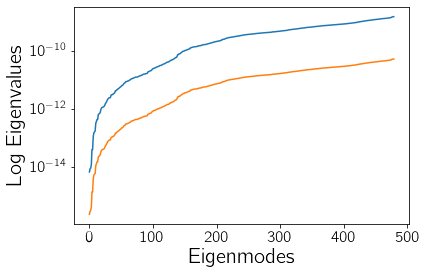

In [56]:
plt.plot(sorted_evals)
plt.plot(test4)
plt.semilogy()
plt.xlabel('Eigenmodes')
plt.ylabel('Log Eigenvalues')

In [57]:
E0_zernike_wfs = np.zeros([N_pup_z*N_pup_z,1,2])
zernike_coeffs = np.zeros([luvoir.sm.num_actuators])
luvoir.sm.actuators = zernike_coeffs
input_wf = luvoir.sm(luvoir.wf_aper)
zernike_ref = zernike.forward(input_wf)
zernike_ref_sub_real = hc.field.subsample_field(zernike_ref.real,10,grid_zernike, statistic='mean')
zernike_ref_sub_imag = hc.field.subsample_field(zernike_ref.imag,10,grid_zernike, statistic='mean')
norm_wfs = np.sum(zernike_ref_sub_real**2+zernike_ref_sub_imag**2)
E0_zernike_wfs[:,0,0] = zernike_ref_sub_real/np.sqrt(norm_wfs)
E0_zernike_wfs[:,0,1] = zernike_ref_sub_imag/np.sqrt(norm_wfs)

In [58]:
zernike_ref_sub_intensity = E0_zernike_wfs[:,0,0]**2+E0_zernike_wfs[:,0,1]**2

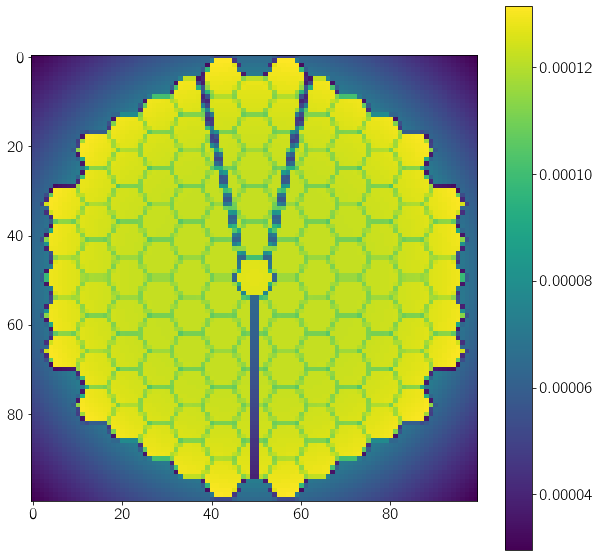

In [59]:
plt.figure(figsize=(10, 10))
plt.imshow(np.reshape(zernike_ref_sub_intensity,[100,100]))
plt.colorbar()

In [60]:
G_zernike_wfs = np.zeros([N_pup_z*N_pup_z,2,number_of_modes])
for kk in range(0,number_of_modes):
    print(kk)
    zernike_coeffs = np.zeros([luvoir.sm.num_actuators])
    zernike_coeffs[kk] = eunit
    luvoir.sm.actuators = zernike_coeffs
    input_wf = luvoir.sm(luvoir.wf_aper)
    zernike_int = zernike.forward(input_wf)
    zernike_int_sub_real = hc.field.subsample_field(zernike_int.real,10,grid_zernike, statistic='mean') 
    zernike_int_sub_imag = hc.field.subsample_field(zernike_int.imag,10,grid_zernike, statistic='mean')
    G_zernike_wfs[:,0,kk] = zernike_int_sub_real/norm_wfs - zernike_ref_sub_real/norm_wfs
    G_zernike_wfs[:,1,kk] = zernike_int_sub_imag/norm_wfs - zernike_ref_sub_imag/norm_wfs

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## JUNK

##### First we need to check if the contrast is porperly normalized

In [117]:
Nph/1e9

579.0117121468245

In [177]:
r = number_of_modes
N = 100*100
N_img = n_img*n_img
# Q = np.eye(r)
fudge_std = 0.03
Q =  np.diag((mu_map*fudge_std)**2)
c = 1
t_exp = 60
flux = Nph/100
# D = Nph/1e9
D = 0
P = Q*0.0

In [180]:
#all values are real
#G - sensitivity matrix of shape (N,2*c,r)
#N - number of pixels
#c - number of channels in one pixel (c=1) for monochromatic light or IFS
#r - number of modes
#Q - covariance of WFE modes (per exposure) of shape (r,r)
#E0 - static electric field of shape (N,1,2*c)
#flux - photon flux (per exposure) (see scaling of intensity at the bottom)
#D - dark current per pixel etc.
Niter = 20
P = Q*0.0 #WFE modes covariance estimate
contrasts = []

#Iterations of ALGORITHM 1
contrast_hist = np.zeros(Niter)
intensity_WFS_hist = np.zeros(Niter)
cal_I_hist = np.zeros(Niter)
eps_hist = np.zeros([Niter,480])
averaged_hist = np.zeros(Niter) 
for pp in range(Niter):
    eps = np.random.multivariate_normal(np.zeros(r), P+Q*t_exp).reshape((1,1,r)) #random modes
    G_eps = np.sum(G_zernike_wfs*eps, axis=2).reshape((N,1,2*c)) + E0_zernike_wfs #electric field
    G_eps_squared = np.sum(G_eps*G_eps, axis=2, keepdims=True)
    G_eps_G = np.matmul(G_eps, G_zernike_wfs)
    G_eps_G_scaled = G_eps_G/np.sqrt(G_eps_squared + D/flux/t_exp) #trick to save RAM
    cal_I = 4*flux*t_exp*np.einsum("ijk,ijl->kl", G_eps_G_scaled, G_eps_G_scaled) #information matrix
#     P = np.linalg.inv(np.linalg.inv(P+Q*t_exp) + cal_I)
#     P = np.linalg.inv(np.linalg.inv(P+Q) + cal_I)
    P = np.linalg.inv(cal_I)

#Coronagraph
    G_eps_coron = np.sum(G_coron*eps, axis=2).reshape((N_img,1,2*c)) + E0_coron
    G_eps_coron_squared = np.sum(G_eps_coron*G_eps_coron, axis=2, keepdims=True)
#     intensity = G_eps_coron_squared*flux*t_exp + D
    intensity = G_eps_coron_squared*flux*t_exp

# Wavefront sensor
    intensity_WFS = G_eps_squared*flux*t_exp + D
    
# Archive
    test_DH0 = intensity[:,0,0]*dh_mask
    test_DH = np.mean(test_DH0[np.where(test_DH0 != 0)])
    contrasts.append(test_DH/flux/np.max(ref_I_1phot_conserved)/t_exp)
    intensity_WFS_hist[pp] = np.sum(intensity_WFS)/flux
    cal_I_hist[pp] = np.mean(cal_I)/flux
    eps_hist[pp] = eps
    averaged_hist[pp] = np.mean(contrasts)
    print("est. contrast", np.mean(contrasts))

est. contrast 4.424862650525288e-11
est. contrast 2.492371229816113e-10
est. contrast 3.059486596460438e-10
est. contrast 3.300990112691588e-10
est. contrast 3.5143180075408235e-10
est. contrast 3.8090902199391557e-10
est. contrast 3.8540516251388187e-10
est. contrast 3.8622522164310213e-10
est. contrast 3.8767729423575583e-10
est. contrast 3.9707190913199227e-10
est. contrast 4.0263301967594506e-10
est. contrast 4.028168374065952e-10
est. contrast 4.023685224148926e-10
est. contrast 4.032810358755211e-10
est. contrast 4.071672153203432e-10
est. contrast 4.107420685697308e-10
est. contrast 4.1337773465221927e-10
est. contrast 4.137040329242392e-10
est. contrast 4.1573736430677033e-10
est. contrast 4.175791701174883e-10


In [ ]:
# averaged_hist1 = averaged_hist

In [170]:
# averaged_hist0 = averaged_hist

In [127]:
averaged_hist2 = averaged_hist

In [ ]:
Change in contrast with m_V = 5$, WFS exposure time 10 mnts, drift 

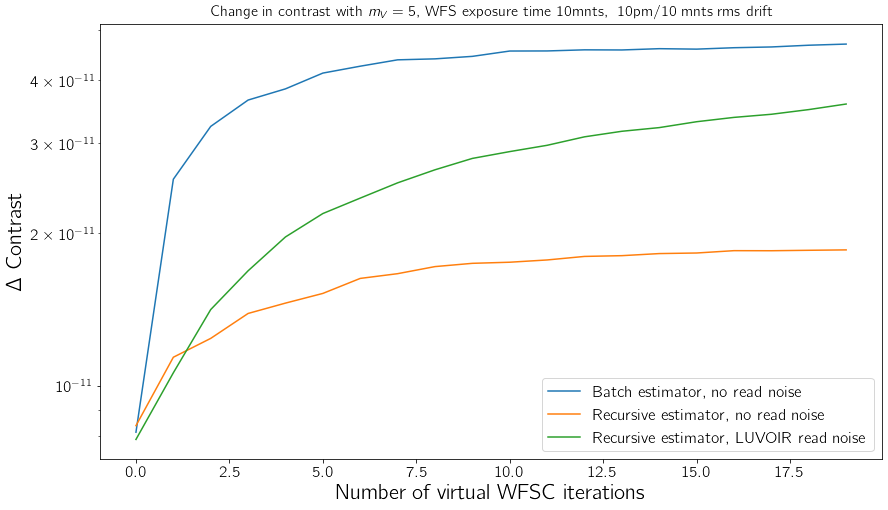

In [187]:
plt.figure(figsize=(14, 8))
plt.plot(averaged_hist0-3.7*10**(-11), label='Batch estimator, no read noise')
plt.plot(averaged_hist1-3.7*10**(-11), label='Recursive estimator, no read noise')
plt.plot(averaged_hist2-3.7*10**(-11), label='Recursive estimator, LUVOIR read noise')
plt.title('Change in contrast with $m_V = 5$, WFS exposure time 10mnts, ~10pm/10 mnts rms drift ', size=15)
plt.semilogy()
plt.xlabel('Number of virtual WFSC iterations')
plt.ylabel('$\Delta$ Contrast')
plt.legend()

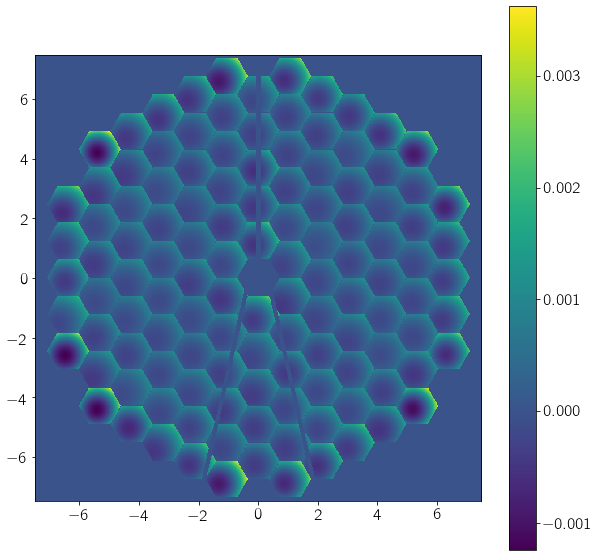

In [150]:
luvoir.sm.actuators = np.reshape(np.std(eps_hist,0),480)*eunit
wf_sm = luvoir.sm(luvoir.wf_aper)
plt.figure(figsize=(10, 10))
hc.imshow_field(wf_sm.phase)
plt.colorbar()
N_zernike = 4
zernike_coeffs_numaps_time = np.zeros([N_zernike,number_of_modes])
for qq in range(N_zernike):
    zernike_coeffs_tmp = np.zeros([number_of_modes])
    for pp in range(120):
        zernike_coeffs_tmp[qq+(pp)*N_zernike] = eps[0,0,qq+(pp)*N_zernike]
    zernike_coeffs_numaps_time[qq] = zernike_coeffs_tmp
nu_maps_time = []
for qq in range(N_zernike):
    zernike_coeffs = eunit*zernike_coeffs_numaps_time[qq]/2
    luvoir.sm.actuators = zernike_coeffs
    nu_maps_time.append(luvoir.sm(luvoir.wf_aper).phase/luvoir.wf_aper.wavenumber)

contrast: 1.0599086637546914e-11
contrast: 1.6602645647277897e-11
contrast: 1.0378810012315574e-11
contrast: 1.2621990459323419e-11


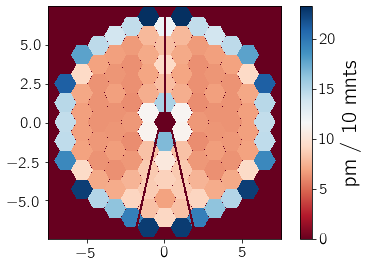

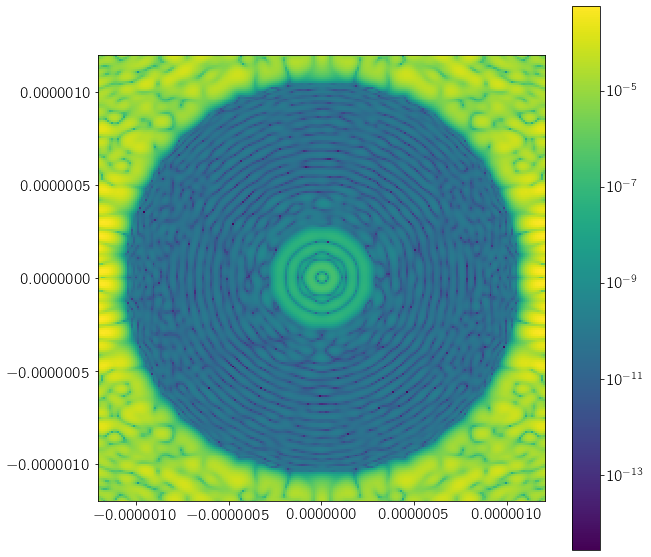

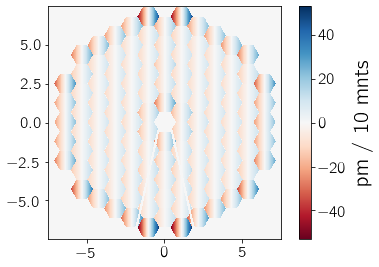

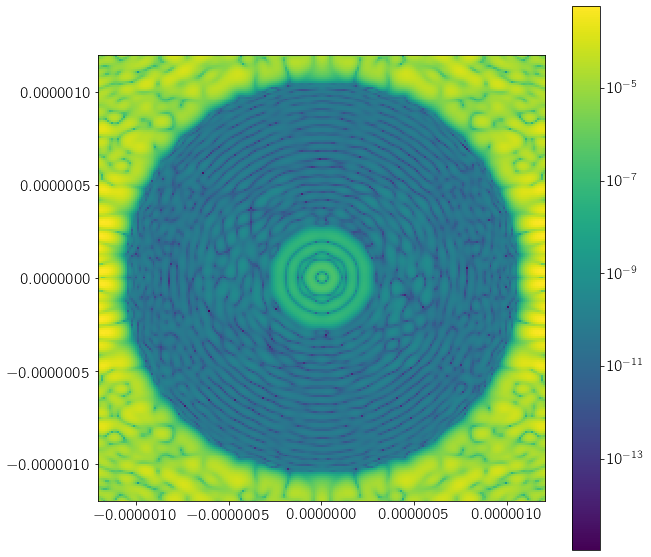

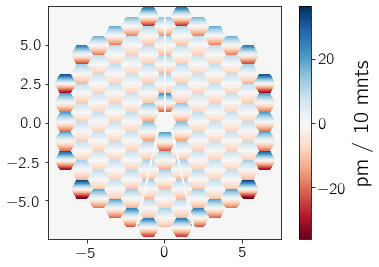

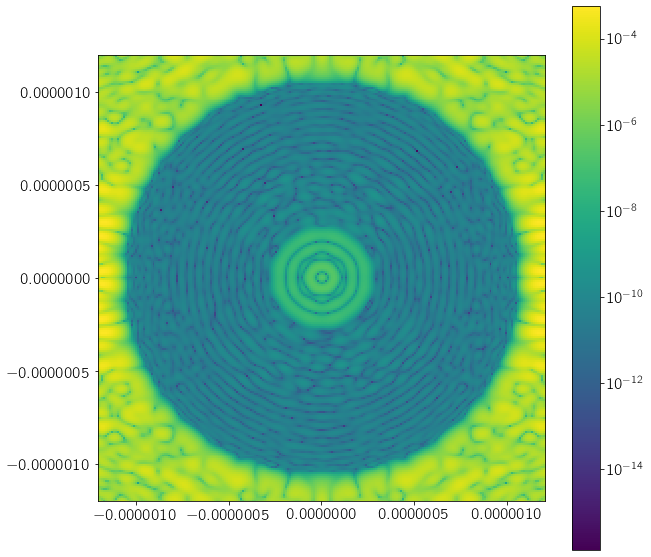

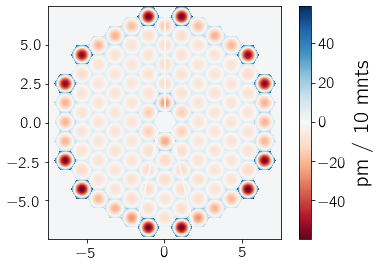

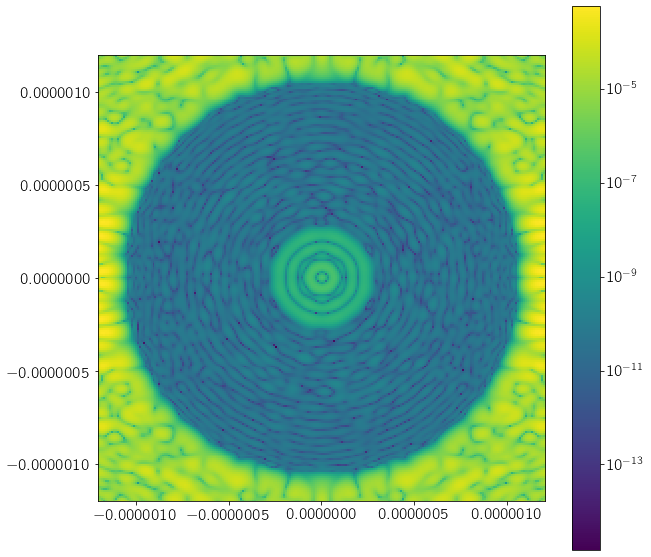

In [185]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(10*fudge_std*nu_maps[0]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm / 10 mnts', rotation=90)
plt.tight_layout(h_pad=1)
zernike_coeffs = zernike_coeffs_numaps_time[0]*eunit / 2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(10*fudge_std*nu_maps[1]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm / 10 mnts', rotation=90)
plt.tight_layout(h_pad=1)
zernike_coeffs = zernike_coeffs_numaps_time[1]*eunit / 2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(10*fudge_std*nu_maps[2]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm / 10 mnts', rotation=90)
plt.tight_layout(h_pad=1)
zernike_coeffs = zernike_coeffs_numaps_time[2]*eunit / 2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(10*fudge_std*nu_maps[3]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm / 10 mnts', rotation=90)
plt.tight_layout(h_pad=1)
zernike_coeffs = zernike_coeffs_numaps_time[3]*eunit / 2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)

contrast: 4.344542897953256e-09
contrast: 7.19107175097212e-09
contrast: 9.200317266901208e-09
contrast: 1.186053496260304e-08


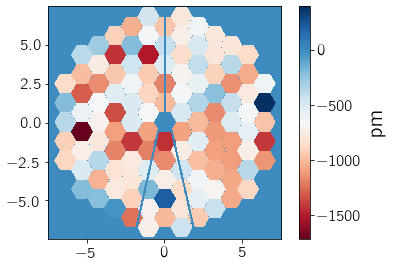

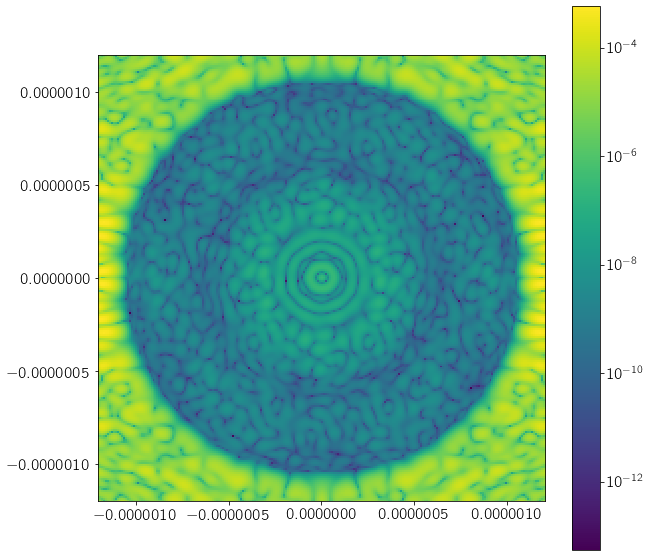

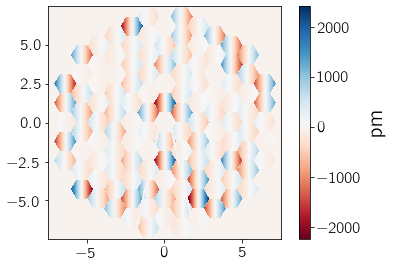

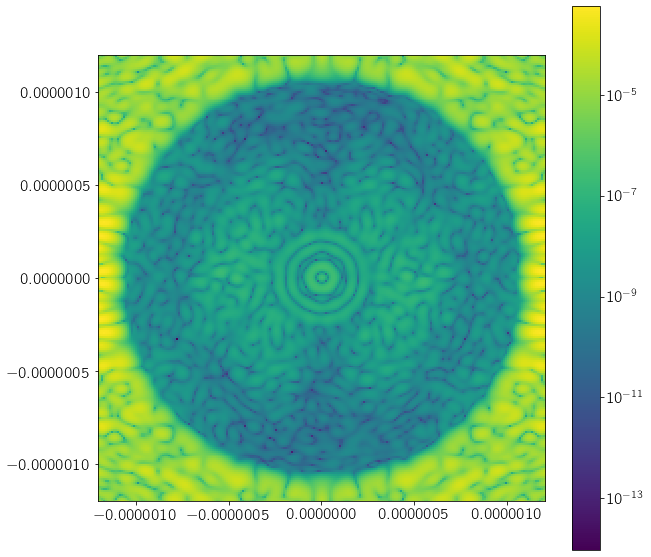

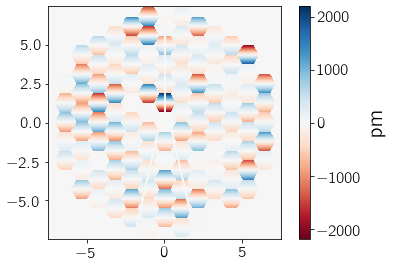

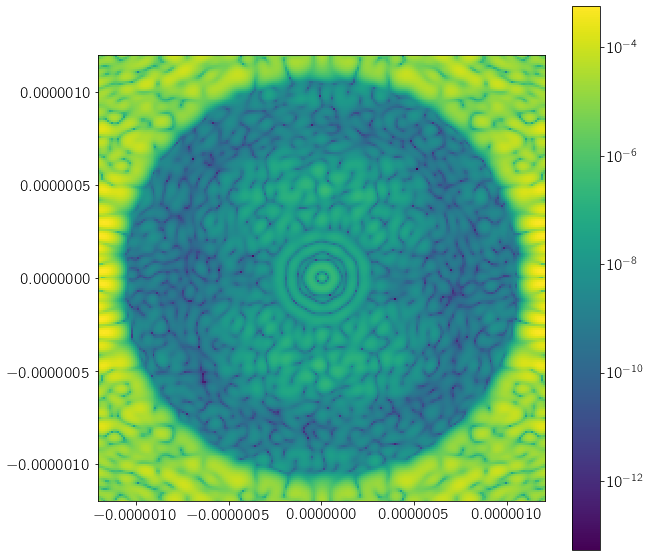

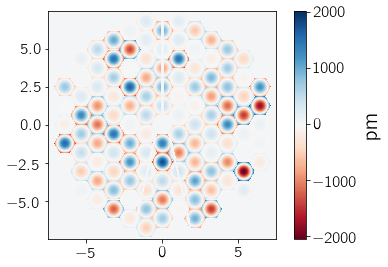

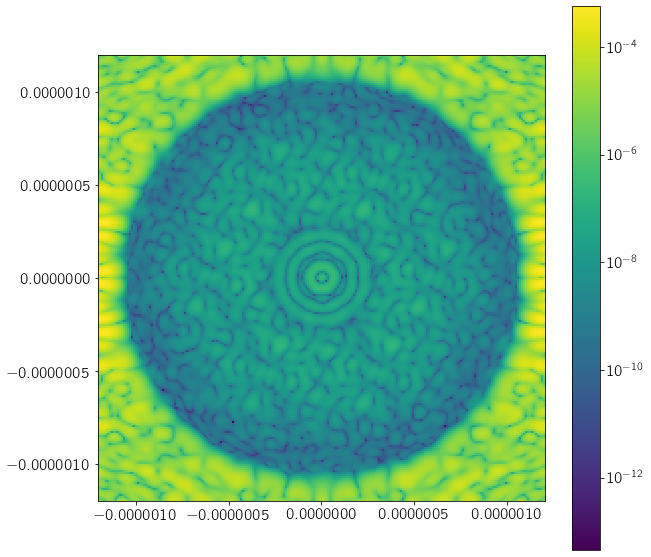

In [129]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps_time[0]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
zernike_coeffs = zernike_coeffs_numaps_time[0]*eunit / 2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps_time[1]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
zernike_coeffs = zernike_coeffs_numaps_time[1]*eunit / 2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps_time[2]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
zernike_coeffs = zernike_coeffs_numaps_time[2]*eunit / 2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps_time[3]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
zernike_coeffs = zernike_coeffs_numaps_time[3]*eunit / 2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)

In [190]:
G_0WFS =  E0_zernike_wfs #electric field
G_0WFS_squared = np.sum(G_0WFS*G_0WFS, axis=2, keepdims=True)

In [193]:
trou= intensity_WFS.reshape([100,100])
trou0= flux*t_exp*G_0WFS_squared.reshape([100,100])

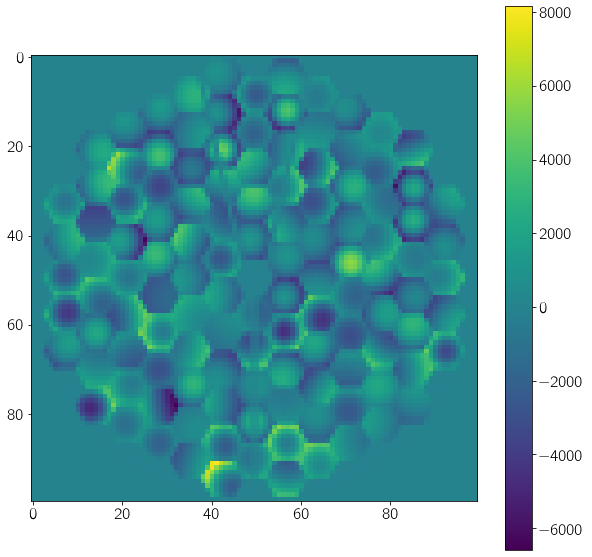

In [195]:
plt.figure(figsize=(10, 10))
plt.imshow(trou - trou0)
plt.colorbar()

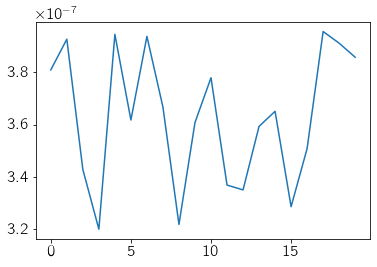

In [76]:
plt.plot(contrasts)